<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-04-tree-based-models-bagging-grf-arm-causal-forest-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.8.4 Multi-arm/multi-outcome Causal Forest

A **Multi-Arm/Multi-Outcome Causal Forest** is an extension of the **Causal Forest** framework designed to estimate heterogeneous treatment effects in scenarios with **multiple treatment arms** (e.g., different interventions) and/or **multiple outcome variables** simultaneously. It builds on random forest principles to provide flexible, data-driven estimates of causal effects across diverse subgroups, leveraging shared information across treatments or outcomes to improve accuracy. This approach is particularly useful in complex experimental designs, such as clinical trials with multiple drugs or policy evaluations with various interventions affecting multiple metrics.

## Overview

A multi-arm/multi-outcome causal forest is an advanced A multi-arm/multi-outcome causal forest is an advanced machine learning method for estimating heterogeneous treatment effects (HTE) in settings with:

-   `Multiple treatments (multi-arm)`: More than two possible interventions or choices, not just "treatment" and "control".

-   `Multiple outcomes (multi-outcome)`: Several different outcome variables of interest, not just a single outcome.

Estimates causal effects (treatment effects) for multiple treatments (arms) or multiple outcomes in a single model, accounting for heterogeneity across covariates (e.g., patient characteristics). It answers questions like: "How does each treatment affect different outcomes across different subgroups?" Handles multiple treatment options (e.g., drug A, drug B, placebo) instead of a single treatment vs. control.

-   Use Cases:

  -   Clinical trials comparing multiple drugs on multiple health outcomes.
  -   Policy evaluation with several interventions and diverse impacts (e.g., education programs affecting test scores and attendance).
  -   Marketing studies analyzing multiple campaign strategies on various customer metrics.



### How It Work

The Multi-Arm/Multi-Outcome Causal Forest builds on the **Generalized Random Forest (GRF)** framework, extending the Causal Forest algorithm (designed for single treatment/outcome) to handle multiple treatments and outcomes. Here’s a step-by-step explanation of its mechanics:

1.  Data Setup

  -   A dataset with:
  -   Covariates $X$ (e.g., patient age, gender).
  -   Treatment assignments $W$, where $W$ can take multiple values (e.g., 0 for control, 1 for treatment A, 2 for treatment B).
  -   Multiple outcome variables $Y_1, Y_2, \ldots, Y_k$ (e.g., different health metrics).

2.  Tree Construction

  -   `Splitting Rule`: Each tree in the forest splits the covariate space to maximize heterogeneity in treatment effects across all arms and outcomes. The splitting criterion optimizes a loss function that measures the quality of treatment effect estimates (e.g., variance of estimated effects).
  -   `Multi-Arm`: For multiple treatments, the tree estimates treatment effects for each arm relative to a baseline (e.g., control) or pairwise differences.
  -   `Multi-Outcome`: For multiple outcomes, the tree models correlations between outcomes, sharing information to improve estimation efficiency (e.g., using a joint loss function or covariance structure).
  -   `Honest Splitting*` Uses separate data for splitting and estimation within each tree to reduce bias (a hallmark of GRF).

3.  Treatment Effect Estimation

  -   For each leaf node in a tree, the algorithm estimates treatment effects for each treatment arm and outcome using local observations.
  -   `Multi-Arm`: Computes the effect of each treatment (e.g., $\tau_j(X) = E[Y | W=j, X] - E[Y | W=0, X]$) for treatment $j$ vs. control).
  -   `Multi-Outcome`: Estimates effects for each outcome (e.g., $\tau_{j,k}(X)$ for treatment $j$ on outcome $k$), often modeling outcome correlations to improve precision.
    -   Methods like local linear regression or moment-based estimation may be used within leaves to estimate effects.

4.  Forest Aggregation

  -   The forest averages predictions across many trees (typically hundreds or thousands) to produce robust estimates.
  -   For a given covariate $X$, the forest outputs a vector of treatment effect estimates for each treatment arm and outcome, e.g., $\hat{\tau}(X) = [\hat{\tau}_{1,1}(X), \hat{\tau}_{1,2}(X), \ldots, \hat{\tau}_{j,k}(X)]$.
  -   Variance estimates are also provided to assess uncertainty.

5.  Handling Complexity

  -   `Multi-Arm`: The forest balances comparisons across multiple treatments, reducing overfitting by sharing information across arms.
  -   `Multi-Outcome`: Leverages correlations between outcomes (e.g., via covariance weighting) to improve efficiency, especially when outcomes are related (e.g., systolic and diastolic blood pressure).
  -   `Nuisance Parameters`: Estimates propensity scores (probability of receiving each treatment) or outcome regressions to adjust for confounding, often using separate forests for these nuisance functions.

6.  Output:

  -   For each individual (defined by covariates $X$, the model provides:
        -   Estimated treatment effects for each treatment arm and outcome.
        -   Confidence intervals or standard errors for uncertainty.
    -   Visualizations or summaries of heterogeneous effects (e.g., which subgroups benefit most from a specific treatment).


### Key Differences from Standard Causal Forest

-   `Standard Causal Forest`: Handles one treatment (binary or continuous) and one outcome, estimating a single treatment effect per individual.
-   `Multi-Arm/Multi-Outcome Causal Forest`:
    -   Models multiple treatments (e.g., multiple drugs) and/or multiple outcomes (e.g., multiple health metrics).
    -   Shares information across arms/outcomes to improve estimation efficiency.
    -   Uses a joint objective function to optimize splits for all treatments and outcomes simultaneously.


### Advantages

-   Handles complex experiments with multiple treatments and outcomes.
-   Captures heterogeneity in treatment effects across subgroups.
-   Robust to non-linear relationships and high-dimensional covariates.
-   Improves efficiency by sharing information across arms/outcomes.


### Limitations

-   Requires sufficient sample size for each treatment arm and outcome.
-   Assumes unconfoundedness (no unmeasured confounders) unless combined with other methods (e.g., instrumental variables).
-   Computationally intensive for large datasets or many outcomes.
-   Interpretability can be challenging due to complex output (multiple effects per individual).

## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [2]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp311-cp311-linux_x86_64.whl


### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Multi-arm/multi-outcome Causal Forestt with R

This tutorial demonstrates how to implement a **multi-arm/multi-outcome causal forest** in R using the `{grf}` package. The example uses the `lung` dataset from the `{survival}` package, simulating a multi-arm treatment scenario with multiple outcomes.



### Load and Check Required Libraries

In [3]:
%%R
packages <- c('tidyverse',
              'plyr',
              'grf',
              'survival',
              'mlbench',
              'Metrics')

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
tidyverse      plyr       grf  survival   mlbench   Metrics 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [4]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))


### Check Loaded Packages

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:Metrics"   "package:mlbench"   "package:survival" 
 [4] "package:grf"       "package:plyr"      "package:lubridate"
 [7] "package:forcats"   "package:stringr"   "package:dplyr"    
[10] "package:purrr"     "package:readr"     "package:tidyr"    
[13] "package:tibble"    "package:ggplot2"   "package:tidyverse"
[16] "package:tools"     "package:stats"     "package:graphics" 
[19] "package:grDevices" "package:utils"     "package:datasets" 
[22] "package:methods"   "package:base"     


### Load and Prepare the Lung Dataset

The lung dataset includes survival data for lung cancer patients. Since lung lacks a treatment variable and multiple outcomes, we:

-   Simulates a multi-arm `treatment` variable with three levels: `placebo`, `A`, and `B` and Assigns probabilities (40% placebo, 30% A, 30% B) for each treatment.

-   Simulates a binary secondary outcome (e.g., `health_status`, 1 = yes, 0 = no) with treatment-dependent probabilities.

-   Use log-transformed survival time (`log_time`) as the primary outcome to ensure numerical stability


In [5]:
%%R

# Load and modify the lung data
data(lung, package = "survival")
lung_data <- lung %>%
  dplyr::filter(!is.na(age), !is.na(sex), !is.na(ph.ecog)) %>%
  dplyr::mutate(
    treatment = as.factor(sample(c("placebo", "A", "B"), n(), replace = TRUE, prob = c(0.4, 0.3, 0.3))),
    health_status = rbinom(n(), 1, prob = 0.3 + 0.1 * (treatment == "A") + 0.15 * (treatment == "B")),
    log_time = log(time)
  )

# Define covariates, treatment, and outcomes
X <- lung_data %>% select(age, sex, ph.ecog) %>% as.matrix()
W <- lung_data$treatment
Y <- lung_data %>% select(log_time, health_status) %>% as.matrix()
colnames(Y) <- c("log_time", "health_status")

# Split into training and test sets
set.seed(123)
n <- nrow(lung_data)
train_idx <- sample(1:n, size = 0.8 * n)
test_idx <- setdiff(1:n, train_idx)
X_train <- X[train_idx, ]
X_test <- X[test_idx, ]
W_train <- W[train_idx]
W_test <- W[test_idx]
Y_train <- Y[train_idx, ]
Y_test <- Y[test_idx, ]

### Train the Multi-arm/Multi-outcome Causal Forest

Since we have multiple treatment arms ("placebo", "A", "B") and multiple outcomes (log_time and health_status), and the grf package’s `multi_arm_causal_forest` function is designed for multiple treatments but a single outcome, we fit a separate model for each outcome.


In [6]:
%%R
macf_log_time <- multi_arm_causal_forest(X = X_train,
                                         Y = Y_train[, "log_time"],
                                         W = W_train)
macf_health_status <- multi_arm_causal_forest(X = X_train,
                                              Y = Y_train[, "health_status"],
                                              W = W_train)

### Predict on the test data set

In [7]:
%%R
# Predict treatment effects
# Predict treatment effects on the test set
tau_hat_log_time <- predict(macf_log_time, newdata = X_test)
tau_hat_health_status <- predict(macf_health_status, newdata = X_test)


### Calculate Doubly Robust Average Treatment Effects (AIPW)

We compute the average treatment effects (ATE) for each arm relative to "placebo" using the doubly robust Augmented Inverse Propensity Weighting (AIPW) method provided by {grf}.

In [8]:
%%R
# Calculate ATE for log_time
ate_log_time <- average_treatment_effect(macf_log_time)

# Calculate ATE for health_status
ate_health_status <- average_treatment_effect(macf_health_status)

# Display the results
print("Average Treatment Effects for log_time:")
print(ate_log_time)
print("Average Treatment Effects for health_status:")
print(ate_health_status)

[1] "Average Treatment Effects for log_time:"
             estimate   std.err    contrast outcome
B - A       0.1989833 0.1810029       B - A     Y.1
placebo - A 0.2795492 0.1632889 placebo - A     Y.1
[1] "Average Treatment Effects for health_status:"
                estimate    std.err    contrast outcome
B - A        0.186669013 0.10536635       B - A     Y.1
placebo - A -0.006616357 0.09235602 placebo - A     Y.1


### Plot Variable Importance

Finally, we plot the importance of each covariate (age, sex, ph.ecog) for each outcome using ggplot2.

#### log_time Outcome

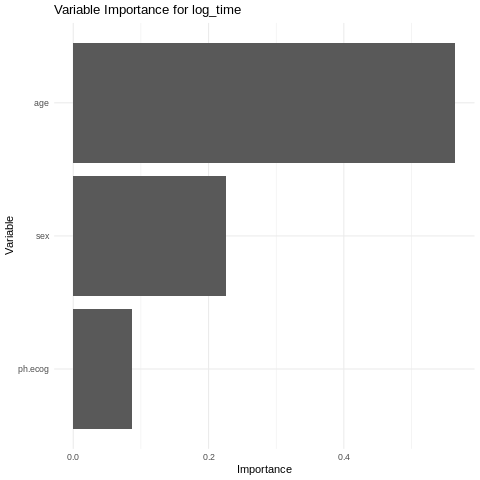

In [9]:
%%R
# Variable importance for log_time
var_imp_log_time <- variable_importance(macf_log_time)
var_imp_df_log_time <- data.frame(
  Variable = colnames(X),
  Importance = var_imp_log_time
)

ggplot(var_imp_df_log_time, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variable Importance for log_time", x = "Variable", y = "Importance") +
  theme_minimal()

#### Health_status Outcome

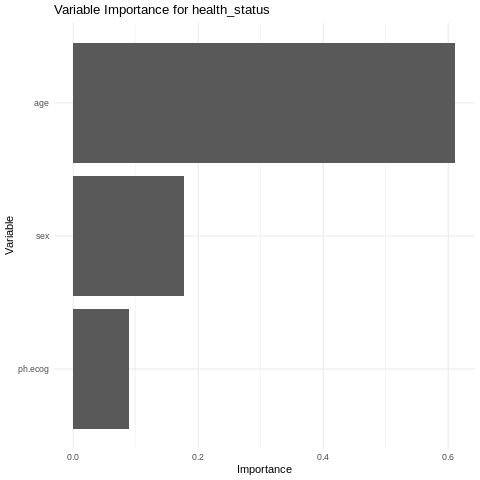

In [10]:
%%R
# Variable importance for health_status
var_imp_health_status <- variable_importance(macf_health_status)
var_imp_df_health_status <- data.frame(
  Variable = colnames(X),
  Importance = var_imp_health_status
)

ggplot(var_imp_df_health_status, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variable Importance for health_status", x = "Variable", y = "Importance") +
  theme_minimal()

## Summary and Conclusion

A Multi-arm/Multi-outcome Causal Forest was applied to the Lung dataset to estimate treatment effects on survival time and health status across three treatment arms: placebo, A, and B. Doubly robust ATEs were computed using AIPW, and variable importance plots identified key covariates like age and sex.

Multi-arm/multi-outcome causal forests are powerful tools for estimating heterogeneous treatment effects in complex settings with multiple treatments and outcomes. By leveraging the flexibility of random forests, they provide robust estimates that account for individual differences and correlations between outcomes. This approach is particularly useful in fields like healthcare, policy evaluation, and marketing, where understanding the nuanced effects of different interventions is crucial. This tutorial demonstrated how to implement a multi-arm/multi-outcome causal forest in R, using the `{grf}` package to analyze treatment effects on multiple outcomes simultaneously. This approach allows researchers to gain deeper insights into the effectiveness of various interventions across diverse populations and outcomes, ultimately leading to more informed decision-making.

## References

1.  Wager, S., & Athey, S. (2018). Estimation and Inference of Heterogeneous Treatment Effects using Random Forests. JASA.

2.  Athey, S., Tibshirani, J., & Wager, S. (2019). Generalized Random Forests. Ann. Statist.

3.  Multi-arm/multi-outcome implementation available in grf R package